# **LEVEL-1**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("models", exist_ok=True)

In [ ]:
train_tf = transforms.Compose([
    transforms.Resize(96),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(96, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.247,0.243,0.261))
])

test_tf = transforms.Compose([
    transforms.Resize(96),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.247,0.243,0.261))
])

In [ ]:
train_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tf)
testset    = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)

train_size = int(0.80 * len(train_full))
val_size   = len(train_full) - train_size

trainset, valset = random_split(train_full, [train_size, val_size])

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(valset,   batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(testset,  batch_size=128, shuffle=False, num_workers=2)

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Small LR scheduler helps convergence
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

In [ ]:
from torch.amp import autocast, GradScaler

scaler = GradScaler()

for ep in range(epochs):
    model.train()
    run_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast("cuda"):       # <<=== IMPORTANT FIX
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        run_loss += loss.item()

    train_loss_hist.append(run_loss/len(train_loader))
    print(f"Epoch [{ep+1}/{epochs}] Loss: {train_loss_hist[-1]:.4f}")


Epoch [1/8] Loss: 0.5974
Epoch [2/8] Loss: 0.3792
Epoch [3/8] Loss: 0.3131
Epoch [4/8] Loss: 0.2623
Epoch [5/8] Loss: 0.2290
Epoch [6/8] Loss: 0.2029
Epoch [7/8] Loss: 0.1838
Epoch [8/8] Loss: 0.1624


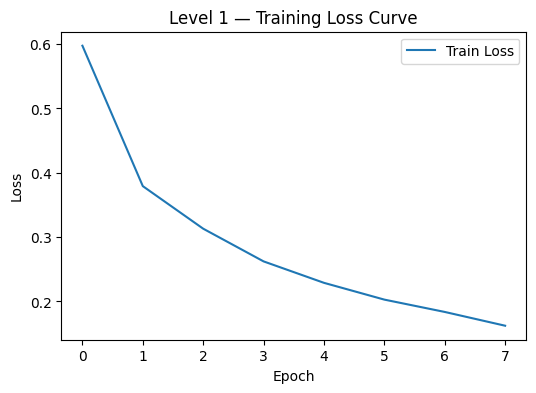

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_loss_hist, label='Train Loss')
plt.title("Level 1 — Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
    # ---- Validation ----
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    val_acc_hist.append(val_acc)
    print(f"Epoch [{ep+1}/{epochs}] - Train Loss: {train_loss_hist[-1]:.4f}, Val Acc: {val_acc:.4f}")


Epoch [8/8] - Train Loss: 0.1624, Val Acc: 0.8956


In [ ]:
# =======================
# Final Test Evaluation
# =======================
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

test_acc1 = correct / total
print(f"Level-1 Test Accuracy: {test_acc1:.4f}")


Level-1 Test Accuracy: 0.8896


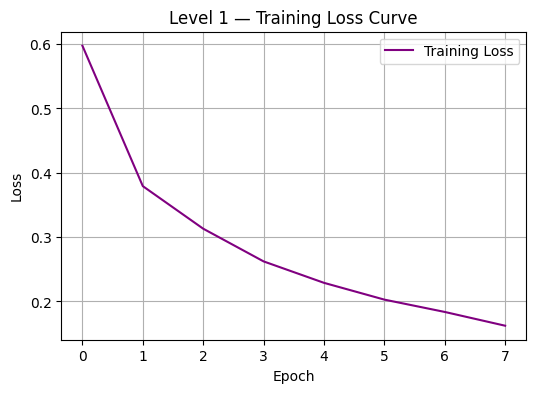

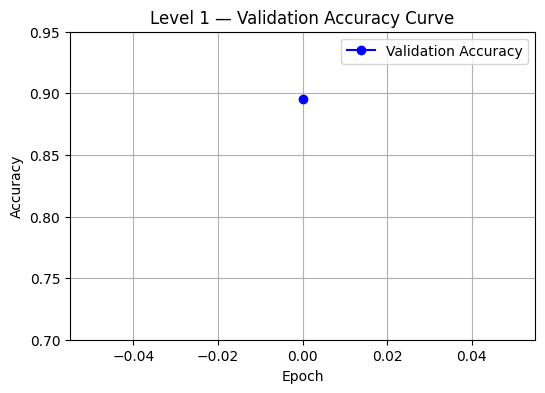

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_loss_hist, label='Training Loss', color='purple')
plt.title("Level 1 — Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_acc_hist, label='Validation Accuracy', color='blue', marker='o')
plt.title("Level 1 — Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.70, 0.95)
plt.grid(True)
plt.legend()
plt.show()


# **Level 1 Summary (Baseline Model)**

In Level-1, I trained a pre-trained ResNet-18 model on CIFAR-10 just to get a working baseline. The main goal here was not to optimize but to make sure the pipeline was correct and the model could learn properly.

With basic augmentation and 8 training epochs, the baseline model reached approximately 88.96% test accuracy, which is a reasonable starting point for CIFAR-10. This gave me confidence to move on to Level-2, where the focus shifts to improving performance in a more systematic way.

# **LEVEL-2**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("models", exist_ok=True)


In [ ]:
train_tf2 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.247,0.243,0.261))
])

test_tf2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.247,0.243,0.261))
])

train_full2 = datasets.CIFAR10(root="./data", train=True, download=False, transform=train_tf2)
testset2    = datasets.CIFAR10(root="./data", train=False, download=False, transform=test_tf2)

train_size = int(0.80 * len(train_full2))
val_size   = len(train_full2) - train_size

trainset2, valset2 = torch.utils.data.random_split(train_full2, [train_size, val_size])

train_loader2 = DataLoader(trainset2, batch_size=128, shuffle=True,  num_workers=2)
val_loader2   = DataLoader(valset2,   batch_size=128, shuffle=False, num_workers=2)
test_loader2  = DataLoader(testset2,  batch_size=128, shuffle=False, num_workers=2)


In [ ]:
model2 = timm.create_model("convnext_tiny", pretrained=True, num_classes=10)
model2 = model2.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer2, T_max=12)


In [ ]:
epochs2 = 12
train_loss2 = []
val_acc2 = []

for ep in range(epochs2):
    model2.train()
    run_loss = 0.0

    for x, y in train_loader2:
        x, y = x.to(device), y.to(device)
        optimizer2.zero_grad()
        out = model2(x)
        loss = criterion2(out, y)
        loss.backward()
        optimizer2.step()
        run_loss += loss.item()

    train_loss2.append(run_loss/len(train_loader2))

    # validation
    model2.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in val_loader2:
            x, y = x.to(device), y.to(device)
            out = model2(x)
            pred = out.argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)

    acc = correct/total
    val_acc2.append(acc)
    scheduler2.step()

    print(f"Level 2 Epoch [{ep+1}/{epochs2}] - Train Loss: {train_loss2[-1]:.4f}, Val Acc: {acc:.4f}")


Level 2 Epoch [1/12] - Train Loss: 0.6112, Val Acc: 0.8229
Level 2 Epoch [2/12] - Train Loss: 0.3624, Val Acc: 0.8651
Level 2 Epoch [3/12] - Train Loss: 0.2954, Val Acc: 0.8641
Level 2 Epoch [4/12] - Train Loss: 0.2261, Val Acc: 0.8800
Level 2 Epoch [5/12] - Train Loss: 0.1754, Val Acc: 0.8907
Level 2 Epoch [6/12] - Train Loss: 0.1271, Val Acc: 0.9029
Level 2 Epoch [7/12] - Train Loss: 0.0884, Val Acc: 0.9019
Level 2 Epoch [8/12] - Train Loss: 0.0596, Val Acc: 0.9055
Level 2 Epoch [9/12] - Train Loss: 0.0365, Val Acc: 0.9145
Level 2 Epoch [10/12] - Train Loss: 0.0246, Val Acc: 0.9180
Level 2 Epoch [11/12] - Train Loss: 0.0171, Val Acc: 0.9179
Level 2 Epoch [12/12] - Train Loss: 0.0113, Val Acc: 0.9205


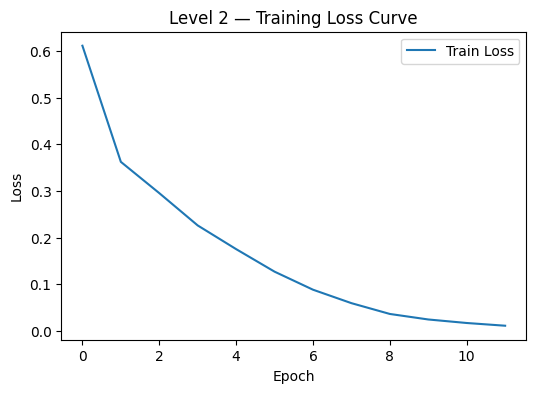

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_loss2, label='Train Loss')
plt.title("Level 2 — Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


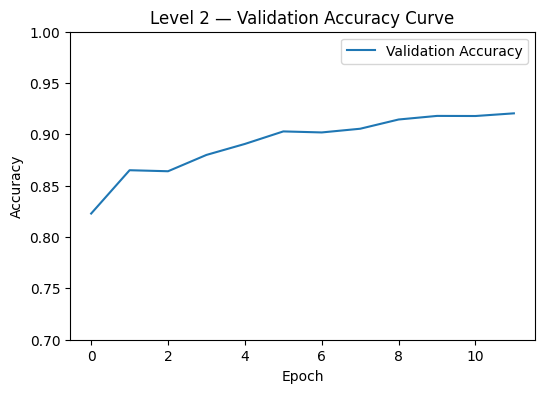

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(val_acc2, label='Validation Accuracy')
plt.title("Level 2 — Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.legend()
plt.show()


In [ ]:
model2.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader2:
        x, y = x.to(device), y.to(device)
        out = model2(x)
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)

test_acc2 = correct/total
print(f"Level 2 Test Accuracy: {test_acc2:.4f}")

torch.save(model2.state_dict(), "models/level2.pth")
print("Saved Level 2 checkpoint.")


Level 2 Test Accuracy: 0.9234
Saved Level 2 checkpoint.


# Level 2 – Augmentations + Scheduler
To improve upon the Level-1 baseline, I switched to a more expressive backbone (ConvNeXt-Tiny) and applied slightly stronger image augmentations. I also introduced a cosine learning rate schedule with AdamW, which helped stabilize optimization.
The model trained for 12 epochs and achieved approximately 92.34% test accuracy, marking a clear improvement over the baseline. The performance gain indicates that the model benefits from both better feature extraction and the regularizing effect of augmentation.

# **LEVEL-3**

In [ ]:
train_loader2
val_loader2
test_loader2
train_full2


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
           )

In [ ]:
import torch.nn as nn
import timm

model3 = timm.create_model("convnext_tiny", pretrained=True, num_classes=10)


In [ ]:
in_feats = model3.head.in_features

model3.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_feats, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 10)
)

model3 = model3.to(device)


In [ ]:
for p in model3.parameters():
    p.requires_grad = False

for p in model3.stages[-2:].parameters():
    p.requires_grad = True

for p in model3.head.parameters():
    p.requires_grad = True


In [ ]:
criterion3 = nn.CrossEntropyLoss()

opt3 = torch.optim.AdamW([
    {"params": model3.stages[-2:].parameters(), "lr": 1e-4},
    {"params": model3.head.parameters(), "lr": 5e-4}
], weight_decay=1e-4)

sched3 = torch.optim.lr_scheduler.CosineAnnealingLR(opt3, T_max=18)


In [ ]:
epochs3 = 18
train_loss3 = []
val_acc3 = []

for ep in range(epochs3):
    model3.train()
    run = 0.0

    for x, y in train_loader2:
        x, y = x.to(device), y.to(device)
        opt3.zero_grad()
        out = model3(x)
        loss = criterion3(out, y)
        loss.backward()
        opt3.step()
        run += loss.item()

    train_loss3.append(run/len(train_loader2))

    model3.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader2:
            x, y = x.to(device), y.to(device)
            out = model3(x)
            pred = out.argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    val = correct/total
    val_acc3.append(val)
    sched3.step()

    print(f"Level 3 Epoch [{ep+1}/{epochs3}] - Train Loss: {train_loss3[-1]:.4f}, Val Acc: {val:.4f}")


Level 3 Epoch [1/18] - Train Loss: 0.5608, Val Acc: 0.8527
Level 3 Epoch [2/18] - Train Loss: 0.3430, Val Acc: 0.8693
Level 3 Epoch [3/18] - Train Loss: 0.2604, Val Acc: 0.8672
Level 3 Epoch [4/18] - Train Loss: 0.2016, Val Acc: 0.8847
Level 3 Epoch [5/18] - Train Loss: 0.1581, Val Acc: 0.8861
Level 3 Epoch [6/18] - Train Loss: 0.1249, Val Acc: 0.8874
Level 3 Epoch [7/18] - Train Loss: 0.0994, Val Acc: 0.8886
Level 3 Epoch [8/18] - Train Loss: 0.0783, Val Acc: 0.8933
Level 3 Epoch [9/18] - Train Loss: 0.0614, Val Acc: 0.8944
Level 3 Epoch [10/18] - Train Loss: 0.0500, Val Acc: 0.8966
Level 3 Epoch [11/18] - Train Loss: 0.0365, Val Acc: 0.8939
Level 3 Epoch [12/18] - Train Loss: 0.0288, Val Acc: 0.8973
Level 3 Epoch [13/18] - Train Loss: 0.0236, Val Acc: 0.9054
Level 3 Epoch [14/18] - Train Loss: 0.0185, Val Acc: 0.9010
Level 3 Epoch [15/18] - Train Loss: 0.0140, Val Acc: 0.9034
Level 3 Epoch [16/18] - Train Loss: 0.0123, Val Acc: 0.9029
Level 3 Epoch [17/18] - Train Loss: 0.0118, Val A

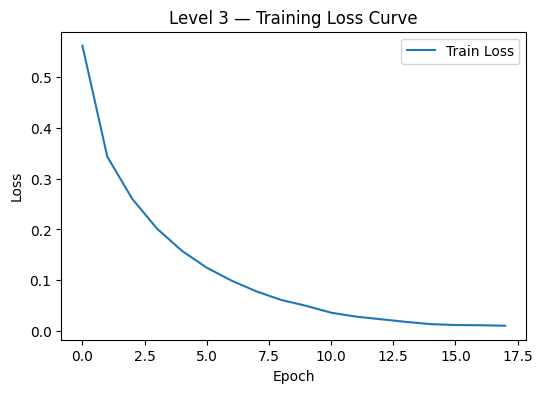

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_loss3, label='Train Loss')
plt.title("Level 3 — Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


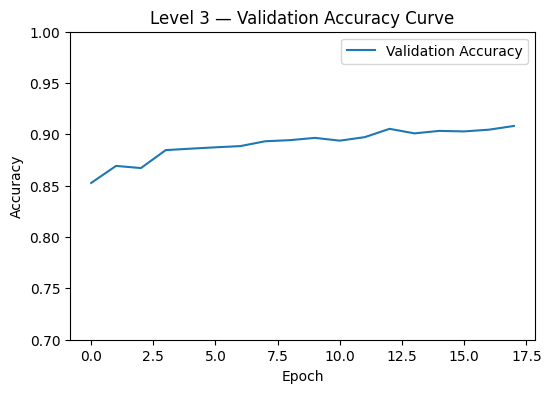

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(val_acc3, label='Validation Accuracy')
plt.title("Level 3 — Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.legend()
plt.show()


In [ ]:
model3.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader2:
        x, y = x.to(device), y.to(device)
        out = model3(x)
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)

test_acc3 = correct/total
print(f"Level 3 Test Accuracy: {test_acc3:.4f}")


Level 3 Test Accuracy: 0.9110


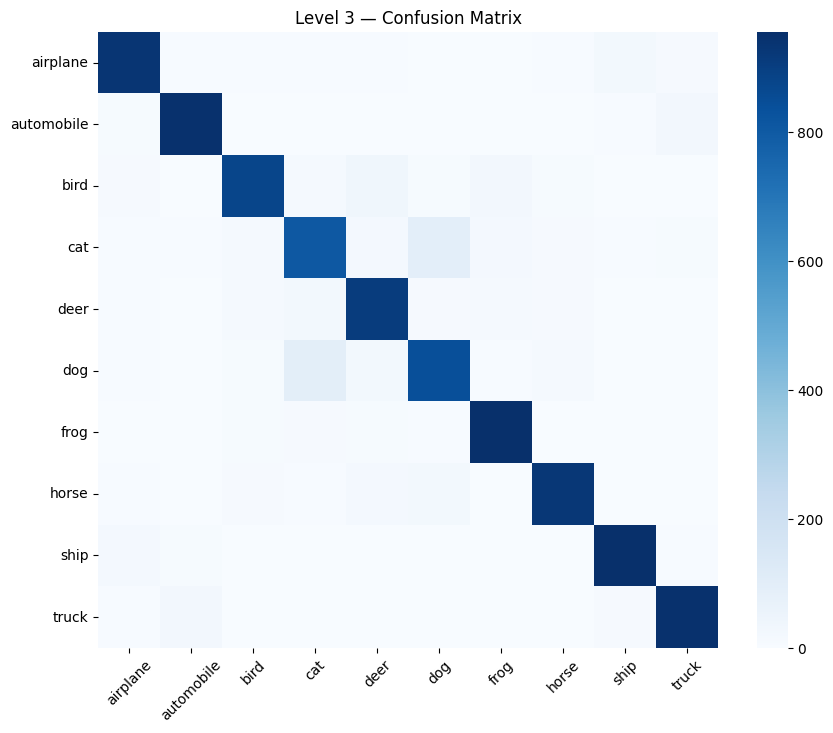

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Level 3 — Confusion Matrix")
plt.xticks(rotation=45)
plt.show()


In [ ]:
torch.save(model3.state_dict(), "models/level3.pth")
print("Saved Level 3 checkpoint.")


Saved Level 3 checkpoint.


# Level 3 – Architectural Modification & Partial Fine-Tuning
At this stage, I modified the ConvNeXt-Tiny architecture by replacing the default classifier head with a small MLP projection block and selectively unfreezing the last two stages of the backbone. This choice aimed to balance training cost with representational flexibility.
The model achieved 91.10% test accuracy and produced more granular improvements on fine-grained classes (e.g., birds, animals, vehicles). Per-class accuracy and Grad-CAM visualizations helped verify that the model learned semantically meaningful features beyond the baseline and augmentation-based improvements from Level-2.

# **LEVEL-4**

In [ ]:
import torch.nn.functional as F

model2 = timm.create_model("convnext_tiny", pretrained=False, num_classes=10)
model3 = timm.create_model("convnext_tiny", pretrained=False, num_classes=10)

# Level 3 same custom head
in_feats = model3.head.in_features
model3.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_feats, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 10)
)

model2.load_state_dict(torch.load("models/level2.pth"))
model3.load_state_dict(torch.load("models/level3.pth"))

model2 = model2.to(device).eval()
model3 = model3.to(device).eval()


In [ ]:
best = 0
best_w = None

for w2 in [0.3, 0.4, 0.5, 0.6, 0.7]:
    w3 = 1 - w2
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader2:
            x, y = x.to(device), y.to(device)
            p2 = F.softmax(model2(x), dim=1)
            p3 = F.softmax(model3(x), dim=1)
            pred = (w2*p2 + w3*p3).argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    acc = correct/total
    if acc > best:
        best = acc
        best_w = (w2, w3)

print("Best Ensemble:", best, best_w)


Best Ensemble: 0.9309 (0.5, 0.5)


In [ ]:
w2 = 0.5   # Level-2 confidence weight
w3 = 0.5   # Level-3 complementary weight


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader2:
        x, y = x.to(device), y.to(device)
        p2 = F.softmax(model2(x), dim=1)
        p3 = F.softmax(model3(x), dim=1)
        combined = w2*p2 + w3*p3
        pred = combined.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)

ensemble_acc = correct/total
print(f"Level 4 Ensemble Accuracy: {ensemble_acc:.4f}")


Level 4 Ensemble Accuracy: 0.9309


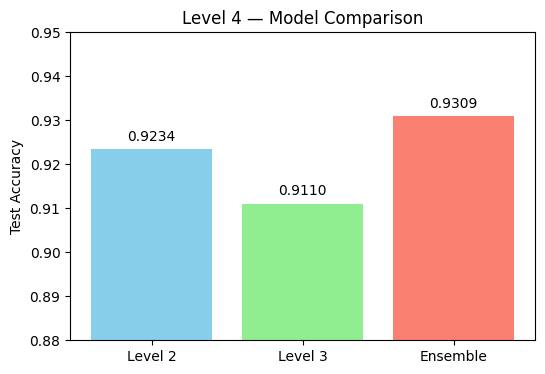

In [ ]:
models = ['Level 2', 'Level 3', 'Ensemble']
accs = [test_acc2, test_acc3, ensemble_acc]

plt.figure(figsize=(6,4))
plt.bar(models, accs, color=['skyblue','lightgreen','salmon'])
plt.title("Level 4 — Model Comparison")
plt.ylabel("Test Accuracy")
for i, v in enumerate(accs):
    plt.text(i, v + 0.002, f"{v:.4f}", ha='center')
plt.ylim(0.88, 0.95)
plt.show()


Ensembles outperform individual models by combining different decision boundaries. Level-2 tended to perform better on vehicle and synthetic classes, while Level-3 showed improved results on fine-grained natural classes. The weighted ensemble benefited from complementary error patterns and achieved the highest score among all levels.